In [1]:
import os

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, cohen_kappa_score, hamming_loss
import joblib
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class CategoricalAutoencoder(nn.Module):
    """
    Autoencoder for categorical data
    Args:
        input_dim (int): Number of categorical input features.
        num_categories (int): Number of unique categories per feature.
        embedding_dim (int): Dimension of the embedding space for each feature.
        encoder_dims (list of int): List specifying the number of neurons in each encoder layer.
        dropout_rate (float): Dropout probability used after each encoder layer.
    """
    def __init__(self, input_dim, num_categories, embedding_dim, encoder_dims, dropout_rate=0.3):
        super(CategoricalAutoencoder, self).__init__()
        self.input_dim = input_dim
        self.num_categories = num_categories
        self.embedding_dim = embedding_dim

        self.embedding = nn.Embedding(num_categories, embedding_dim)

        encoder_layers = []
        current_dim = input_dim * embedding_dim
        for dim in encoder_dims:
            encoder_layers.append(nn.Linear(current_dim, dim))
            encoder_layers.append(nn.ReLU())
            encoder_layers.append(nn.Dropout(dropout_rate))
            current_dim = dim
        self.encoder = nn.Sequential(*encoder_layers)

        decoder_dims = encoder_dims[::-1] + [input_dim * num_categories]
        decoder_layers = []
        current_dim = decoder_dims[0]
        for dim in decoder_dims[1:]:
            decoder_layers.append(nn.Linear(current_dim, dim))
            decoder_layers.append(nn.ReLU() if dim != input_dim * num_categories else nn.Identity())
            current_dim = dim
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        """
        Forward pass of the autoencoder.
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, input_dim) with categorical indices.

        Returns:
            decoded (torch.Tensor): Reconstructed logits of shape (batch_size, input_dim, num_categories).
            encoded (torch.Tensor): Encoded latent representation of the input.
        """
        embedded = self.embedding(x)
        embedded = embedded.view(x.size(0), -1)
        encoded = self.encoder(embedded)
        decoded = self.decoder(encoded)
        return decoded.view(x.size(0), self.input_dim, self.num_categories), encoded

In [ ]:
class CategoricalDataset(Dataset):
    """
    Class for categorical dataset
    Converts a pandas DataFrame of categorical values into a tensor of type LongTensor,
    suitable for use with embedding layers.

    Args:
        X (pd.DataFrame): DataFrame containing categorical feature values (as integers).
    """
    def __init__(self, X):
        self.X = torch.LongTensor(X.values)

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.X)

    def __getitem__(self, idx):
        """
        Returns the sample at the specified index.

        Args:
            idx (int): Index of the sample to retrieve.
            
        Returns:
            torch.Tensor: Categorical input tensor for one sample.
        """
        return self.X[idx]

In [ ]:
def train_autoencoder(model, dataloader, epochs=10, lr=1e-3, l1_reg=1e-5):
    """
    Trains a categorical autoencoder

    Args:
        model (nn.Module): The autoencoder model to be trained.
        dataloader (DataLoader): Dataloader providing batches of categorical input data.
        epochs (int): Number of training epochs.
        lr (float): Learning rate for the optimizer.
        l1_reg (float): Coefficient for L1 regularization applied to encoded latent vectors.
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            batch = batch.to(device)
            output, encoded = model(batch)
            loss = sum(criterion(output[:, i], batch[:, i]) for i in range(batch.shape[1])) #  # Calculate reconstruction loss using cross-entropy for each categorical feature
            loss += l1_reg * encoded.abs().sum() # Add L1 regularization on the encoded vector to encourage sparsity
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

In [ ]:
df = pd.read_pickle("data/div_div_df_012.pkl.gz")

In [33]:
df.head()

,NC_024462.2:176591192,NC_024465.2:107146403,NC_024462.2:175124560,NC_024466.2:152343269,NC_024459.2:174140196,NC_024463.2:190062160,NC_024459.2:105238339,NC_024468.2:121322607,NC_024464.2:149570979,NC_024460.2:32496541,...,NC_024465.2:72970699,NC_024463.2:205894490,NC_024463.2:216732095,NC_024462.2:178938885,NC_024460.2:16401606,NC_024461.2:218604096,NC_024468.2:1609581,NC_024465.2:30219158,NC_024468.2:88558005,Heterotic group
0,0,2,0,2,2,0,1,2,0,2,...,0,0,0,0,2,0,0,0,0,NSS
1,0,0,1,2,0,2,2,2,1,2,...,0,0,2,0,0,0,1,0,0,SPT
2,0,0,0,1,0,0,0,2,0,2,...,0,0,1,1,1,1,0,1,0,NSS
3,0,0,0,2,0,2,0,2,0,2,...,0,2,1,1,0,1,1,0,2,PB
4,2,0,0,2,0,0,0,2,0,2,...,0,1,2,0,2,0,2,0,0,PA


In [ ]:
# Preparing the data for the autoencoder

# Separate features and target column
X = df.drop(columns=['Heterotic group'])
y = df['Heterotic group']

# Encode target labels as integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Define key parameters for the autoencoder
num_categories = 3
input_dim = X.shape[1]
ae_epochs=10
encoder_dims=[512, 256, 128, 64]
embedding_dim=3
batch_size=64

dataset = CategoricalDataset(X)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize the categorical autoencoder model
ae_model = CategoricalAutoencoder(
        input_dim=input_dim,
        num_categories=num_categories,
        embedding_dim=embedding_dim,
        encoder_dims=encoder_dims
    ).to(device)

In [ ]:
# Autoencoder training
train_autoencoder(ae_model, dataloader, epochs=ae_epochs)

Epoch 1, Loss: 348151.4824
Epoch 2, Loss: 271849.9590
Epoch 3, Loss: 264406.3301
Epoch 4, Loss: 261746.4590
Epoch 5, Loss: 261225.8184
Epoch 6, Loss: 260817.5859
Epoch 7, Loss: 260592.7285
Epoch 8, Loss: 260080.9902
Epoch 9, Loss: 259627.7793
Epoch 10, Loss: 260307.1504


In [ ]:
# Extracting embeddings from the trained autoencoder
dataset = CategoricalDataset(X)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

# Set the autoencoder to evaluation mode
ae_model.eval()
all_encoded = [] # # List to store encoded representations for all batches

with torch.no_grad():
    for batch in dataloader:
        batch = batch.to(device)
        _, encoded = ae_model(batch)
        all_encoded.append(encoded.cpu().numpy())
X_encoded = np.concatenate(all_encoded, axis=0)

In [ ]:
# Load embeddings if need
# X_encoded = torch.load('AE_embeddings_40k.pth', weights_only=False)

In [ ]:
# Split the data into train and test. And split test data into val and test
X_train, X_temp, y_train, y_temp = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Catboost hyperparameters
catboost_base_params = {
    'iterations': 100,
    'learning_rate': 0.05,
    'depth': 4,
    'l2_leaf_reg': 10,
    'loss_function': 'MultiClass',
    'eval_metric': 'TotalF1',
    'verbose': 100,
    'random_seed': 111,
    'early_stopping_rounds': 20,
    'used_ram_limit': '32gb',
    'thread_count': 1,
    'bagging_temperature': 0.8
}

# Catboost model
clf = CatBoostClassifier(
        iterations=100,
        learning_rate=0.05,
        depth=4,
        l2_leaf_reg=10,
        loss_function='MultiClass',
        eval_metric='TotalF1',
        verbose=100,
        random_seed=42,
        early_stopping_rounds=20,
        used_ram_limit='32gb',
        thread_count=1,
        bagging_temperature=0.8
    )

In [ ]:
# Catboost training
clf.fit(X_train, y_train, eval_set=(X_val, y_val))

0:	learn: 0.6382859	test: 0.5755615	best: 0.5755615 (0)	total: 173ms	remaining: 17.2s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7536832277
bestIteration = 46

Shrink model to first 47 iterations.


In [10]:
train_accuracy_filtered_data = accuracy_score(y_train, clf.predict(X_train))
test_accuracy_filtered_data = accuracy_score(y_test, clf.predict(X_test))
print(f"Train accuracy: {train_accuracy_filtered_data}")
print(f"Test accuracy: {test_accuracy_filtered_data}")

train_precision = precision_score(y_train, clf.predict(X_train), average='weighted')
test_precision = precision_score(y_test, clf.predict(X_test), average='weighted')
print(f"Train precision: {train_precision}")
print(f"Test precision: {test_precision}")

train_recall = recall_score(y_train, clf.predict(X_train), average='weighted')
test_recall = recall_score(y_test, clf.predict(X_test), average='weighted')
print(f"Train recall: {train_recall}")
print(f"Test recall: {test_recall}")

train_f1 = f1_score(y_train, clf.predict(X_train), average='weighted')
test_f1 = f1_score(y_test, clf.predict(X_test), average='weighted')
print(f"Train F1-score: {train_f1}")
print(f"Test F1-score: {test_f1}")

train_roc_auc = roc_auc_score(y_train, clf.predict_proba(X_train), multi_class='ovr')
test_roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test), multi_class='ovr')
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Test ROC AUC: {test_roc_auc}")

Train accuracy: 0.8033126293995859
Test accuracy: 0.7377049180327869
Train precision: 0.7622083967905894
Test precision: 0.6843091334894613
Train recall: 0.8033126293995859
Test recall: 0.7377049180327869
Train F1-score: 0.7729603522335023
Test F1-score: 0.7030965391621129
Train ROC AUC: 0.9726783597087024
Test ROC AUC: 0.9327660678709548


d:\Pytorch_Cuda\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Pytorch_Cuda\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


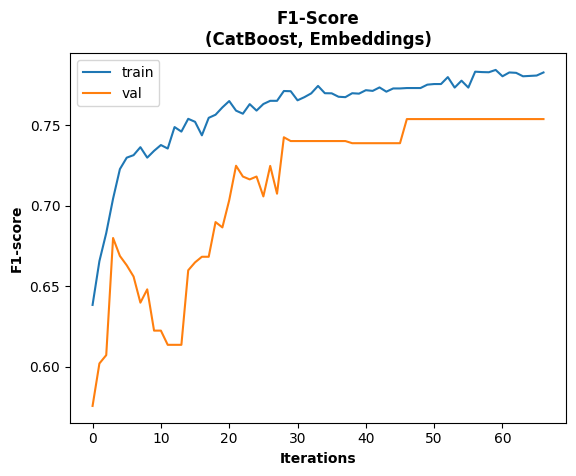

In [ ]:
# Make a curve of F1-Score per interations
results = clf.evals_result_
plt.plot(results['learn']['TotalF1'], label='train')
plt.plot(results['validation']['TotalF1'], label='val')
plt.legend()
plt.title('F1-Score\n(CatBoost, Embeddings)', fontweight='bold')
plt.xlabel('Iterations', fontweight='bold')
plt.ylabel('F1-score', fontweight='bold')
plt.show()

In [ ]:
# Saving the autoencoder
torch.save(ae_model.state_dict(), "autoencoder_40k.pth")

In [ ]:
# Saving Catboost model
joblib.dump(clf, 'Catboost_AE_40k.pkl')

['Catboost_AE_40k.pkl']

In [ ]:
# Saving embeddings
torch.save(X_encoded, 'AE_embeddings_40k.pth')

In [ ]:
# Restoring the dataframe
model = ae_model.eval()
data_tensor = torch.LongTensor(df.drop(columns=["Heterotic group"]).values).to(device)

with torch.no_grad():
    reconstructed_probs, _ = model(data_tensor)
    reconstructed_labels = torch.argmax(reconstructed_probs, dim=-1)

decoded_df = pd.DataFrame(reconstructed_labels.cpu().numpy(), columns=df.drop(columns=["Heterotic group"]).columns)
print("\n Восстановленный датафрейм:")
print(decoded_df.head())


 Восстановленный датафрейм:
   NC_024462.2:176591192  NC_024465.2:107146403  NC_024462.2:175124560  \
0                      0                      0                      0   
1                      0                      0                      0   
2                      0                      0                      0   
3                      0                      0                      0   
4                      0                      0                      0   

   NC_024466.2:152343269  NC_024459.2:174140196  NC_024463.2:190062160  \
0                      2                      0                      0   
1                      2                      0                      0   
2                      2                      0                      0   
3                      2                      0                      0   
4                      2                      0                      0   

   NC_024459.2:105238339  NC_024468.2:121322607  NC_024464.2:149570979  \
0      

In [14]:
ae_model = torch.load('autoencoder_40k.pth', weights_only=False)

In [ ]:
# Assessment of recovery metrics
true_labels = data_tensor.cpu().numpy().flatten()
pred_labels = reconstructed_labels.cpu().numpy().flatten()

accuracy = accuracy_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels, average='macro')
kappa = cohen_kappa_score(true_labels, pred_labels)
hamming = hamming_loss(true_labels, pred_labels)

print("\n Метрики качества автоэнкодера:")
print(f'Accuracy:      {accuracy:.4f}')
print(f'F1-score:      {f1:.4f}')
print(f'Cohen’s Kappa: {kappa:.4f}')
print(f'Hamming Loss:  {hamming:.4f}')


 Метрики качества автоэнкодера:
Accuracy:      0.7720
F1-score:      0.5651
Cohen’s Kappa: 0.4456
Hamming Loss:  0.2280


In [56]:
X_encoded = torch.load('AE_embeddings_40k.pth', weights_only=False)

In [ ]:
def cross_validate_catboost_cool(X, y, n_splits=5):
    """ 
    Perform stratified k-fold cross-validation using a CatBoostClassifier and report performance metrics.

    Parameters:
        X (array-like): Feature matrix of shape (n_samples, n_features).
        y (array-like): Target labels of shape (n_samples,).
        n_splits (int): Number of folds for stratified cross-validation (default is 5).

    Prints:
        Accuracy, F1-score, and ROC AUC for each fold.
        Mean and standard deviation for each metric across all folds.
    """

    # Initialize stratified k-fold cross-validator to maintain label distribution across folds
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Lists to store performance metrics
    accuracy_list = []
    f1_list = []
    roc_auc_list = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

        # Initialize the CatBoost classifier with specified hyperparameters
        model = CatBoostClassifier(
        iterations=100,
        learning_rate=0.05,
        depth=4,
        l2_leaf_reg=10,
        loss_function='MultiClass',
        eval_metric='TotalF1',
        verbose=100,
        random_seed=42,
        early_stopping_rounds=20,
        used_ram_limit='32gb',
        thread_count=1,
        bagging_temperature=0.8
    )
        # Train the model on the training set, using the validation set for early stopping
        model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=False)

        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)

        # Compute performance metrics
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro')
        roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test), multi_class='ovr')

        accuracy_list.append(acc)
        f1_list.append(f1)
        roc_auc_list.append(roc_auc)

        print(f"\n Fold {fold}:")
        print(f"  Accuracy: {acc:.4f}")
        print(f"  F1-score: {f1:.4f}")
        print(f"  Roc Auc: {roc_auc:.4f}")

    print("\n Cross-validation summary:")
    print(f"Accuracy: {np.mean(accuracy_list):.4f} ± {np.std(accuracy_list):.4f}")
    print(f"F1-score: {np.mean(f1_list):.4f} ± {np.std(f1_list):.4f}")
    print(f"Roc Auc: {np.mean(roc_auc_list):.4f} ± {np.std(roc_auc_list):.4f}")


In [13]:
cross_validate_catboost_cool(X_encoded, y_encoded)


 Fold 1:
  Accuracy: 0.7541
  F1-score: 0.6664
  Roc Auc: 0.9328

 Fold 2:
  Accuracy: 0.7869
  F1-score: 0.6959
  Roc Auc: 0.9328

 Fold 3:
  Accuracy: 0.7705
  F1-score: 0.6934
  Roc Auc: 0.9328

 Fold 4:
  Accuracy: 0.7541
  F1-score: 0.6717
  Roc Auc: 0.9328

 Fold 5:
  Accuracy: 0.7377
  F1-score: 0.6601
  Roc Auc: 0.9328

 Cross-validation summary:
Accuracy: 0.7607 ± 0.0167
F1-score: 0.6775 ± 0.0145
Roc Auc: 0.9328 ± 0.0000
